In [17]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import optax
import jax.lax as lax

## Part 1: Forward simulation in 1D

Simplified 1D model: only have x dimension (u)
\begin{aligned}
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - \frac{\partial p}{\partial x}  + \nu \frac{\partial^2 u}{\partial x^2} \\\\
\end{aligned}

Heat evolution:
\begin{align}
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} = \kappa \nabla^2 T
\end{align}

In [18]:
Lx = 10
nx = 100
dx = Lx / (nx - 1)
dt = 0.001
nu = 10
diffusivity = 0.001
dpdx = 0.5

x = jnp.linspace(0, Lx, nx)




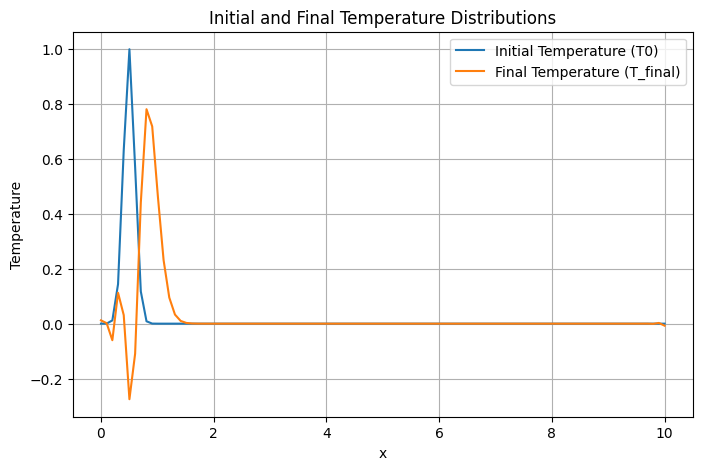

In [19]:
T0 = jnp.exp(-0.5 * ((x - 0.5) / 0.1) ** 2) # initial temperature distribution
u = 1.0 * jnp.ones_like(x) # Initial velocity field

@jax.jit
def heat_evolution(T, u, dx, dt, diffusivity):
    dTdx = (jnp.roll(T, -1) - jnp.roll(T, 1)) / (2 * dx)
    d2Tdx2 = (jnp.roll(T, -1) - 2*T + jnp.roll(T, 1)) / dx**2
    T_rhs = -u * dTdx + diffusivity * d2Tdx2
    T_new = T + dt * T_rhs
    return T_new

@jax.jit
def velocity_evolution(u, dx, dt, nu, dpdx):
    dudx = (jnp.roll(u, -1) - jnp.roll(u, 1)) / (2 * dx)
    d2udx2 = (jnp.roll(u, -1) - 2*u + jnp.roll(u, 1)) / dx**2
    u_rhs = -u * dudx - dpdx + nu * d2udx2
    u_new = u + dt * u_rhs
    return u_new

def run_forward_phase(T0, u0, dx, dt, diffusivity, nu, dpdx, num_steps):
    T, u = T0.copy(), u0.copy()
    for _ in range(num_steps):
        T = heat_evolution(T, u, dx, dt, diffusivity)
        u = velocity_evolution(u, dx, dt, nu, dpdx)
    return T 

T_final = run_forward_phase(T0, u, dx, dt, diffusivity, nu, dpdx, num_steps=500)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, T0, label='Initial Temperature (T0)')
plt.plot(x, T_final, label='Final Temperature (T_final)')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title('Initial and Final Temperature Distributions')
plt.legend()
plt.grid(True)
plt.show()


## Part 2: Forward simulation in 2D
Simplified representation of stratospheric wind velocity: 2D incompressible Navier-Stokes equations with Coriolis force in Cartesian (ignore vertical structures)
\begin{align}
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - v \frac{\partial u}{\partial y} - \frac{\partial p}{\partial x} + f v + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \\
\frac{\partial v}{\partial t} &= -u \frac{\partial v}{\partial x} - v \frac{\partial v}{\partial y} - \frac{\partial p}{\partial y} - f u + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{align}

where:
- u, v are wind velocity components in the x, y directions
- p is pressure
- f: Coriolis parameter
- \nu: kinematic viscosity (laminar flow)

since the vertical pressure gradient is dominant in the stratosphere, we've set a constant background pressure gradient

Heat evolution: 
\begin{align}
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} + v \frac{\partial T}{\partial y} = \kappa \nabla^2 T
\end{align}

In [20]:
# Parameters
f = 1e-4    # Coriolis parameter (s^-1)
nu = 10    # Viscosity
diffusivity = 0.01
Lx = 10 # Domain size in x (m)
Ly = 10 # Domain size in y (m)
nx = 100     # Grid points in x
ny = 100    # Grid points in y

# Create grid
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
X, Y = jnp.meshgrid(x, y, indexing='ij')

In [21]:
# helper functions: computed using finite difference with periodic BCs
def laplacian(field, dx, dy):
    d2f_dx2 = (jnp.roll(field, -1, axis=1) - 2*field + jnp.roll(field, 1, axis=1)) / (dx**2)
    d2f_dy2 = (jnp.roll(field, -1, axis=0) - 2*field + jnp.roll(field, 1, axis=0)) / (dy**2)
    return d2f_dx2, d2f_dy2

def gradient(field, dx, dy):
    dfdx = (jnp.roll(field, -1, axis=1) - jnp.roll(field, 1, axis=1)) / (2*dx)
    dfdy = (jnp.roll(field, -1, axis=0) - jnp.roll(field, 1, axis=0)) / (2*dy)
    return dfdx, dfdy

def divergence(u, v, dx, dy):
    du_dx = (jnp.roll(u, -1, axis=1) - jnp.roll(u, 1, axis=1)) / (2 * dx)
    dv_dy = (jnp.roll(v, -1, axis=0) - jnp.roll(v, 1, axis=0)) / (2 * dy)
    return du_dx + dv_dy

def pressure_gradient(t):
    # constant background atmospheric pressure gradient
    dp_dx = 0.5
    dp_dy = 0.5
    return dp_dx, dp_dy

def solve_poisson(source, dx, dy, n_iter=200, tolerance=1e-8):
    p = jnp.zeros_like(source)
    dx2, dy2 = dx**2, dy**2
    factor = dx2 * dy2 / (2 * (dx2 + dy2))
    
    for i in range(n_iter):
        p_new = factor * (
            (jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0)) / dy2 +
            (jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1)) / dx2 -
            source
        )
        
        # Check convergence occasionally
        if i % 50 == 0:
            residual = jnp.max(jnp.abs(p_new - p))
            if residual < tolerance:
                break
        p = p_new
    
    return p

def solve_poisson(source, dx, dy, n_iter=200, tolerance=1e-8):
    dx2, dy2 = dx**2, dy**2
    factor = dx2 * dy2 / (2 * (dx2 + dy2))
    
    def body(i, p):
        p_new = factor * (
            (jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0)) / dy2 +
            (jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1)) / dx2 -
            source
        )
        return p_new

    p0 = jnp.zeros_like(source)
    p = lax.fori_loop(0, n_iter, body, p0)
    return p


In [22]:
def streamfunction_to_velocity(psi, dx, dy):
    # to ensure incompressiblity of a 2D flow
    # psi is a scalar field
    dpsi_dx, dpsi_dy = gradient(psi, dx, dy)
    u = -dpsi_dy
    v = dpsi_dx
    return u, v

In [23]:
def coupled_NS_heat(t, state, args):
    psi, T = state # stream function and temperature (stream function ensures incompressibility of velocity field)
    u, v = streamfunction_to_velocity(psi, dx, dy)

    # Navier-Stokes equations for velocity field
    du_dx, du_dy = gradient(u, dx, dy)
    dv_dx, dv_dy = gradient(v, dx, dy)
    d2u_dx2, d2u_dy2 = laplacian(u, dx, dy)
    d2v_dx2, d2v_dy2 = laplacian(v, dx, dy)
    dp_dx, dp_dy = pressure_gradient(t)

    du_dt = - (u * du_dx + v * du_dy + dp_dx) + f * v + nu * (d2u_dx2 + d2u_dy2)
    dv_dt = - (u * dv_dx + v * dv_dy + dp_dy) - f * u + nu * (d2v_dx2 + d2v_dy2)

    # need to solve for dpsi/dt from du_dt and dv_dt:
    # ∂/∂x(∂v/∂t) - ∂/∂y(∂u/∂t) = ∇²(∂ψ/∂t): vorticity = laplacian(streamfunction)
    dv_dt_dx, _ = gradient(dv_dt, dx, dy)
    _, du_dt_dy = gradient(du_dt, dx, dy)
    vorticity = dv_dt_dx - du_dt_dy
    dpsi_dt = solve_poisson(vorticity, dx, dy)

    # head advection-diffusion for temperature
    dT_dx, dT_dy = gradient(T, dx, dy)
    d2T_dx2, d2T_dy2 = laplacian(T, dx, dy)
    dT_dt = - (u * dT_dx + v * dT_dy) + diffusivity * (d2T_dx2 + d2T_dy2)

    return (dpsi_dt, dT_dt)    

In [24]:
@jax.jit
def simulate(psi0, T0, t_end):
    initial_state = (psi0, T0)
    term = diffrax.ODETerm(coupled_NS_heat)
    solver = diffrax.Tsit5()
    #saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_end, 10))
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-5)
    solution = diffrax.diffeqsolve(
        term,
        solver,
        t0=0,
        t1=t_end,
        dt0=0.01,
        y0=initial_state,
        max_steps=10000000,
    )

    psi_final, T_final = solution.ys # final streamfunction + temp
    #return psi_final, T_final, solution.ts
    return psi_final, T_final

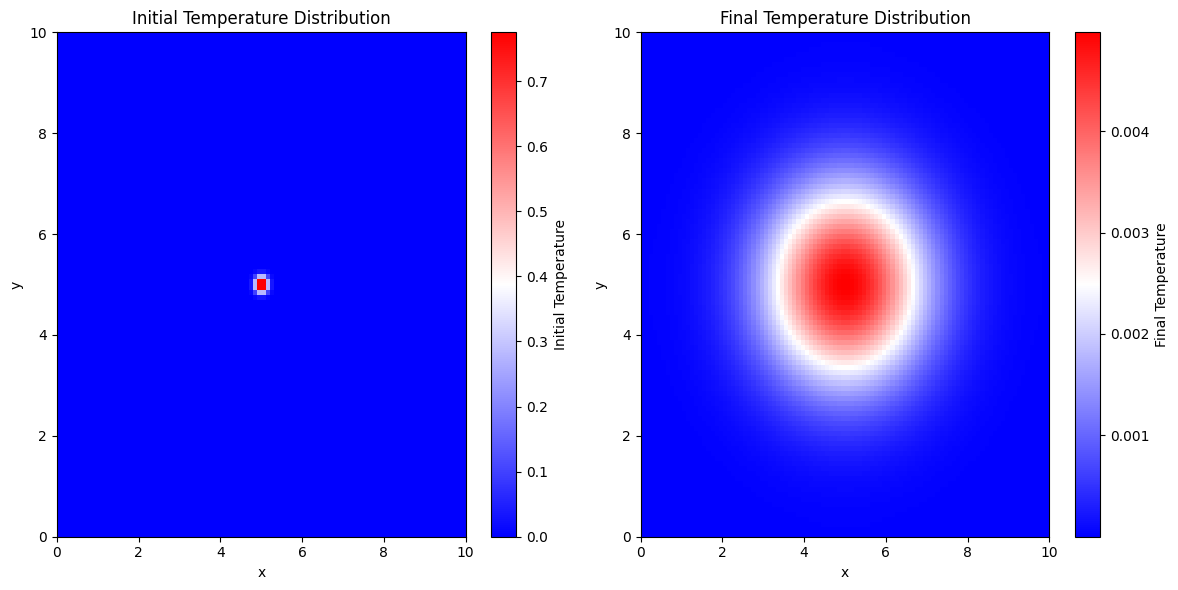

In [25]:
# Gaussian parameters
x0 = Lx / 2  # center x
y0 = Ly / 2  # center y
sigma_x = 0.1  # std in x
sigma_y = 0.1  # std in y

# 2D Gaussian
gaussian = jnp.exp(-(((X - x0) ** 2) / (2 * sigma_x ** 2) +
                    ((Y - y0) ** 2) / (2 * sigma_y ** 2)))
T0 = jnp.array(gaussian, dtype=jnp.float32)  # initial temperature distribution
psi0 = jnp.zeros_like(T0)  # initial streamfunction 
psi_final, T_final = simulate(psi0, T0, t_end=100)

# Plotting
plt.figure(figsize=(12,6))
# plot initial and final temperature distributions 
plt.subplot(1, 2, 1)
plt.imshow(T0, extent=(0, Lx, 0, Ly), origin='lower', aspect='auto', cmap='bwr')
plt.colorbar(label='Initial Temperature')
plt.title('Initial Temperature Distribution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.imshow(T_final[0], extent=(0, Lx, 0, Ly), origin='lower', aspect='auto', cmap='bwr')
plt.colorbar(label='Final Temperature')
plt.title('Final Temperature Distribution')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [26]:
print(T_final)

[[[6.4524123e-08 6.8298320e-08 7.5988673e-08 ... 7.5988673e-08
   6.8298320e-08 6.4524123e-08]
  [6.8298320e-08 7.2293268e-08 8.0433466e-08 ... 8.0433459e-08
   7.2293261e-08 6.8298320e-08]
  [7.5988680e-08 8.0433466e-08 8.9490243e-08 ... 8.9490229e-08
   8.0433459e-08 7.5988673e-08]
  ...
  [7.5988673e-08 8.0433459e-08 8.9490236e-08 ... 8.9490229e-08
   8.0433459e-08 7.5988673e-08]
  [6.8298320e-08 7.2293261e-08 8.0433459e-08 ... 8.0433452e-08
   7.2293261e-08 6.8298320e-08]
  [6.4524123e-08 6.8298313e-08 7.5988673e-08 ... 7.5988666e-08
   6.8298320e-08 6.4524123e-08]]]


In [27]:
# Create initial and target heat fields
def create_initial_heat_field():
    """Hot spot on the left side"""
    return 10.0 * jnp.exp(-((X - 0.3*Lx)**2 + (Y - 0.5*Ly)**2) / (2 * (0.1*Lx)**2))

def create_target_heat_field():
    """Target: hot spot moved to the right side"""
    return 8.0 * jnp.exp(-((X - 0.7*Lx)**2 + (Y - 0.6*Ly)**2) / (2 * (0.15*Lx)**2))

T_initial = create_initial_heat_field()
T_target = create_target_heat_field()

In [28]:
# plot initial and target heat fields


## Part 3: Optimization

In [31]:

def loss_fn(psi_params, T0, T_target):
    psi_initial = psi_params.reshape((nx, ny))
    psi_final, T_final = simulate(psi_initial, T0, t_end = 100)

    # MSE for heat field matchiing:
    heat_loss = jnp.mean((T_final - T_target)**2)
    return heat_loss 



In [ ]:

def optimize_coupled_system():
    #Optimize initial stream function for the complete coupled system
    # Initialize parameters
    key = jax.random.PRNGKey(42)
    psi_params = 1e-2 * jax.random.normal(key, (nx * ny,))
    
    # Setup optimizer
    optimizer = optax.adam(learning_rate=100)  # Slower learning for stability
    opt_state = optimizer.init(psi_params)
    
    losses = []
    
    for i in range(150):  # More iterations for coupled system
        loss, grads = jax.value_and_grad(loss_fn)(psi_params, T_initial, T_target)
        
        # Update parameters
        updates, opt_state = optimizer.update(grads, opt_state, psi_params)
        psi_params = optax.apply_updates(psi_params, updates)
        
        # Clip to reasonable bounds
        psi_params = jnp.clip(psi_params, -1e2, 1e2)
        
        losses.append(loss)
        
        if i % 30 == 0:
            print(f"Iteration {i}")
            print(f"  Loss: {loss:.6f}")
            # Test current solution
            psi_test = psi_params.reshape((nx, ny))
            u_test, v_test = streamfunction_to_velocity(psi_test, dx, dy)
            max_speed = jnp.max(jnp.sqrt(u_test**2 + v_test**2))
            print(f"  Current max velocity: {max_speed:.2f} m/s")
    
    return psi_params, losses

psi_optimized, loss_history = optimize_coupled_system()
# get final results
psi_initial_opt = psi_optimized.reshape((nx, ny))
psi_final_opt, T_final_opt = simulate(psi_initial_opt, T_initial)

# initial and final velocity fields
u_initial, v_initial = streamfunction_to_velocity(psi_initial_opt, dx, dy)
u_final, v_final = streamfunction_to_velocity(psi_final_opt, dx, dy)

# Verify incompressibility
div_initial = divergence(u_initial, v_initial, dx, dy)
div_final = divergence(u_final, v_final, dx, dy)

print(f"\nResults:")
print(f"Initial velocity divergence - Max: {jnp.max(jnp.abs(div_initial)):.2e}, RMS: {jnp.sqrt(jnp.mean(div_initial**2)):.2e}")
print(f"Final velocity divergence - Max: {jnp.max(jnp.abs(div_final)):.2e}, RMS: {jnp.sqrt(jnp.mean(div_final**2)):.2e}")
print(f"Heat transport MSE: {jnp.mean((T_final_opt - T_target)**2):.6f}")
print(f"Initial max velocity: {jnp.max(jnp.sqrt(u_initial**2 + v_initial**2)):.2f} m/s")
print(f"Final max velocity: {jnp.max(jnp.sqrt(u_final**2 + v_final**2)):.2f} m/s")



TypeError: Input z must be 2D, not 3D

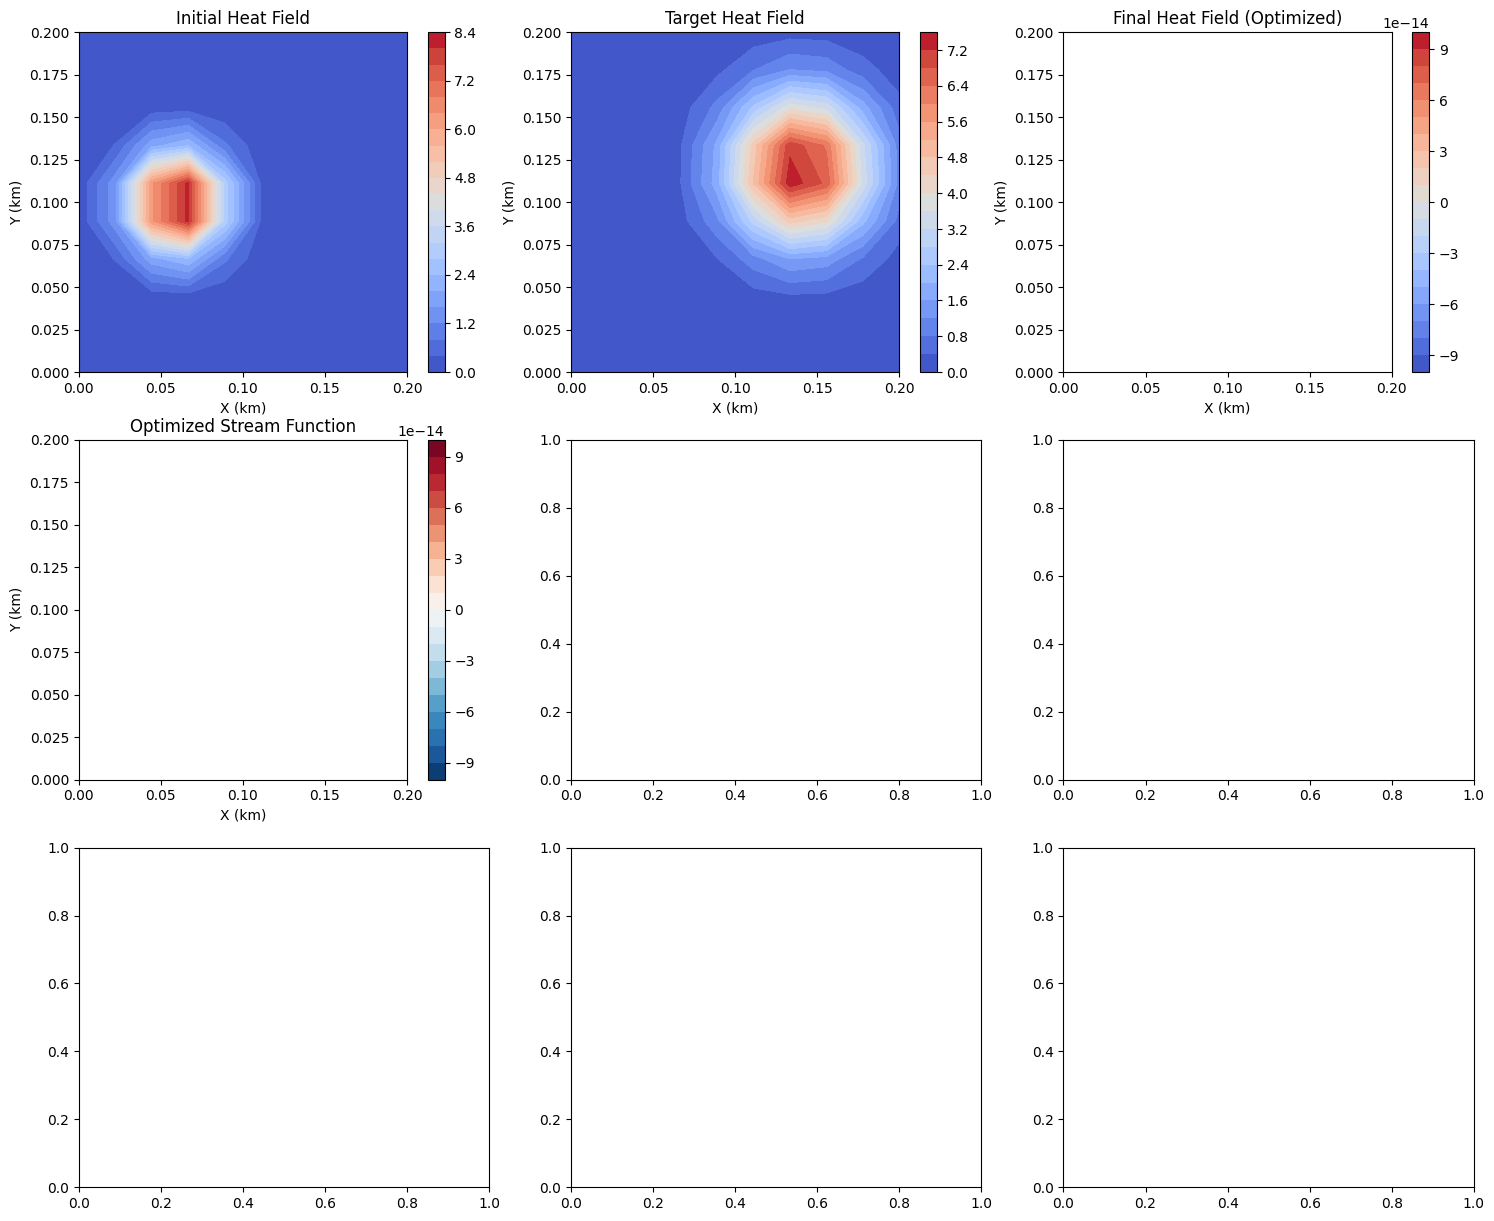

In [ ]:
# plotting
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

X_km = X / 1e3
Y_km = Y / 1e3

# Row 1: Heat evolution
axes[0, 0].contourf(X_km, Y_km, T_initial, levels=20, cmap='coolwarm')
axes[0, 0].set_title('Initial Heat Field')

axes[0, 1].contourf(X_km, Y_km, T_target, levels=20, cmap='coolwarm')
axes[0, 1].set_title('Target Heat Field')

#axes[0, 2].contou

# Row 1: Heat fields
im1 = axes[0, 0].contourf(X_km, Y_km, T_initial, levels=20, cmap='coolwarm')
axes[0, 0].set_title('Initial Heat Field')
axes[0, 0].set_xlabel('X (km)')
axes[0, 0].set_ylabel('Y (km)')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].contourf(X_km, Y_km, T_target, levels=20, cmap='coolwarm')
axes[0, 1].set_title('Target Heat Field')
axes[0, 1].set_xlabel('X (km)')
axes[0, 1].set_ylabel('Y (km)')
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[0, 2].contourf(X_km, Y_km, T_final_opt[0], levels=20, cmap='coolwarm')
axes[0, 2].set_title('Final Heat Field (Optimized)')
axes[0, 2].set_xlabel('X (km)')
axes[0, 2].set_ylabel('Y (km)')
plt.colorbar(im3, ax=axes[0, 2])

# Row 2: Stream function and velocity
im4 = axes[1, 0].contourf(X_km, Y_km, psi_final_opt[0], levels=20, cmap='RdBu_r')
axes[1, 0].set_title('Optimized Stream Function')
axes[1, 0].set_xlabel('X (km)')
axes[1, 0].set_ylabel('Y (km)')
plt.colorbar(im4, ax=axes[1, 0])

# Velocity field
speed = jnp.sqrt(u_final**2 + v_final**2)
im5 = axes[1, 1].contourf(X_km, Y_km, speed, levels=20, cmap='viridis')
step = 2
axes[1, 1].quiver(X_km[::step, ::step], Y_km[::step, ::step], 
                  u_final[::step, ::step], v_final[::step, ::step], 
                  color='white', alpha=0.8, scale=300)
axes[1, 1].set_title('Velocity Field (Incompressible)')
axes[1, 1].set_xlabel('X (km)')
axes[1, 1].set_ylabel('Y (km)')
plt.colorbar(im5, ax=axes[1, 1], label='Speed (m/s)')

plt.tight_layout()
plt.show()





In [ ]:
import sys

def print_dependencies():
    print("\n=== Dependencies ===")
    print(f"Python: {sys.version.split()[0]}")
    import jax, diffrax, optax, matplotlib, numpy
    print(f"JAX: {jax.__version__}")
    print(f"Diffrax: {diffrax.__version__}")
    print(f"Optax: {optax.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    print(f"Numpy: {numpy.__version__}")
    print("====================\n")

print_dependencies()



=== Dependencies ===
Python: 3.13.1
JAX: 0.6.2
Diffrax: 0.7.0
Optax: 0.2.5
Matplotlib: 3.10.3
Numpy: 2.3.1

